MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

In [1]:
# for calculating notebook runtime
import time
start_time = time.time()

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import random

# Set the random seeds
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

from keras.models import Sequential, Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, concatenate
from keras.wrappers.scikit_learn import KerasClassifier

from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

# 1 &nbsp; `Data Exploration (Access, Preprocessimg, and Deriving Features`

Data exploration has been previously explained, discussed, and completed in HW2.  
We are importing this data as explored, cleaned, and prepared with subsets combined.

In [4]:
excel_file = 'weld_defect_dataset.xlsx'

# gather data from excel file
subsets = []
for i in range(1, 6):
    subset = pd.read_excel(excel_file, sheet_name = 'subset' + str(i))
    subset = subset.rename(columns={'Type':'type','W':'w','Ar':'ar','Sp':'sp','Re':'re','Rr':'rr','Sk':'sk','Ku':'ku','Hc':'hc','Rc':'rc','Sc ':'sc','Kc ':'kc'}) # note the space after Sc and Kc are errors in naming in the excel file and are corrected here for ease of use later
    subsets.append(subset)
df = pd.concat(subsets, ignore_index=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Features
nums = list(df.select_dtypes(include=['float64']).columns)
df[nums] = StandardScaler().fit_transform(df[nums])

# Target
types = df['type'].unique().tolist()
print('types:',types)
cat_type = CategoricalDtype(categories=types, ordered=True) # specify the order of categories (stop it from going in alphabetical order; good for confusion matricies comparisons to paper later)
df['type'] = df['type'].astype(cat_type) # convert column to categorical type
df['type_copy'] = df['type'] # create column for get_dummies() to work on so that we keep the orignal 'type' columns afterwards
df = pd.get_dummies(df, columns=['type_copy'], prefix=['type']) # get dummies

# excel_file_clean = excel_file.split('.')[0]+'_clean.xlsx'
# df.to_excel(excel_file_clean, index=False)
# df # clean and prepped dataframe

types: ['PO', 'SL', 'LP', 'LF', 'CR']


For Reference: 

`Defect Features:`

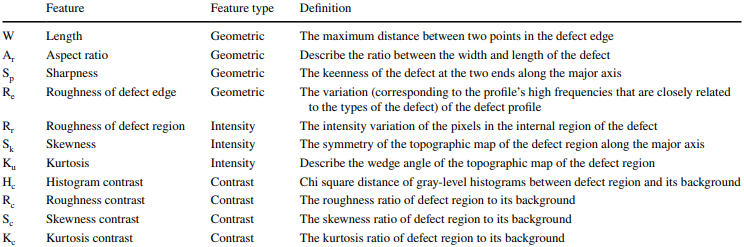

`Defect Types:`  
- `PO` = porosity
- `SL` = slag inclusion
- `LP` = lack of penetration
- `LF` = lack of fusion
- `CR` = crack


Useing `.info()` and `.describe()` for data confirmation and reference:

In [5]:
# df.info()

In [6]:
# df[nums].describe()

In [7]:
# sns.pairplot(df, vars=nums, hue='type', diag_kind='kde')

In [8]:
# sns.heatmap(df[nums].corr(), annot=True)

# 2 &nbsp; `Train`

We will begin by splitting our data into training and testing sets, using a 20% test size:

In [9]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values
y = df['type'].values
y = LabelEncoder().fit_transform(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


Construct basic artificial neural network (ANN) model with Keras:

explain why relu and sigmoid - sigmoid needed for outet - relu needed earlier due to vanishing gradient problem it does best on (as in reaserch paper)

We will create a functioin of a basic ANN model and then created differenent instances basese on different params, skips, etc.

In [10]:
def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
                       optimizer='adam', learning_rate=0.001, regularization_factor=0.01):
    '''
    How to call:
    model_name = create_keras_model(n_features, n_classes, hidden_nodes=[[5, 2], [10, 4], [15, 8]], 
                                    optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
    '''

    # input layer
    inputs = Input(shape=(input_dim,))

    # lists to hold hidden layers
    hidden_layers = []
    compressed_layers = []

    # create hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))
        
        # compression layer
        compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))

    # concatenate the compressed layers
    concatenated = concatenate(compressed_layers)

    # output layer, directly connected to the concatenated layer
    outputs = Dense(output_dim, activation='softmax')(concatenated)

    # create model
    model = Model(inputs=inputs, outputs=outputs)

    # define optimizer with the given learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

# model = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
#                            optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
# model.summary()
# plot_model(model, show_shapes=True)

In [11]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store evaluation results across folds
# accuracy_scores_train = []
# accuracy_scores_test = []

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]
    
#     # Define early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=100)
#     # Train the model
#     model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
#     # Test your model's performance on the training and test sets
#     Y_pred_train = model.predict(X_train)
#     Y_pred_test = model.predict(X_test)
    
#     # Convert the prediction probabilities into class predictions
#     y_pred_train = (Y_pred_train > 0.5).astype(int)
#     y_pred_test = (Y_pred_test > 0.5).astype(int)
    
#     # Evaluate the model's performance on the testing set
#     # accuracy_score doesn't work with multilabel output, you need to use some other metric
#     # One possibility is average accuracy per class
#     accuracy_train = np.mean([accuracy_score(Y_train[:, i], y_pred_train[:, i]) for i in range(Y_train.shape[1])])
#     accuracy_test = np.mean([accuracy_score(Y_test[:, i], y_pred_test[:, i]) for i in range(Y_test.shape[1])])
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_test.append(accuracy_test)
    
# # Aggregate the evaluation results across folds
# mean_accuracy_train = np.mean(accuracy_scores_train)
# mean_accuracy_test = np.mean(accuracy_scores_test)
# print(f'Mean training accuracy over {kf.n_splits} folds: {mean_accuracy_train:.6f}')
# print(f'Mean testing accuracy over {kf.n_splits} folds: {mean_accuracy_test:.6f}')

In [12]:
model_prod = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
                                optimizer='adam', learning_rate=0.001, regularization_factor=0.01)

# Define early stopping callback
early_stop_prod = EarlyStopping(monitor='val_loss', patience=100)
# Train the model
model_prod_fit = model_prod.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop_prod])

Epoch 1/1000
175/175 [==============================] - 2s 5ms/step - loss: 1.5946 - accuracy: 0.2686 - val_loss: 1.5525 - val_accuracy: 0.4318
Epoch 2/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.4399 - accuracy: 0.4514 - val_loss: 1.3121 - val_accuracy: 0.4545
Epoch 3/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.2133 - accuracy: 0.4514 - val_loss: 1.1068 - val_accuracy: 0.4545
Epoch 4/1000
175/175 [==============================] - 1s 3ms/step - loss: 1.0695 - accuracy: 0.4514 - val_loss: 0.9968 - val_accuracy: 0.4773
Epoch 5/1000
175/175 [==============================] - 0s 3ms/step - loss: 0.9781 - accuracy: 0.5029 - val_loss: 0.9284 - val_accuracy: 0.5455
Epoch 6/1000
175/175 [==============================] - 0s 3ms/step - loss: 0.9081 - accuracy: 0.6400 - val_loss: 0.8696 - val_accuracy: 0.5909
Epoch 7/1000
175/175 [==============================] - 0s 3ms/step - loss: 0.8593 - accuracy: 0.6514 - val_loss: 0.8227 - val_accuracy:

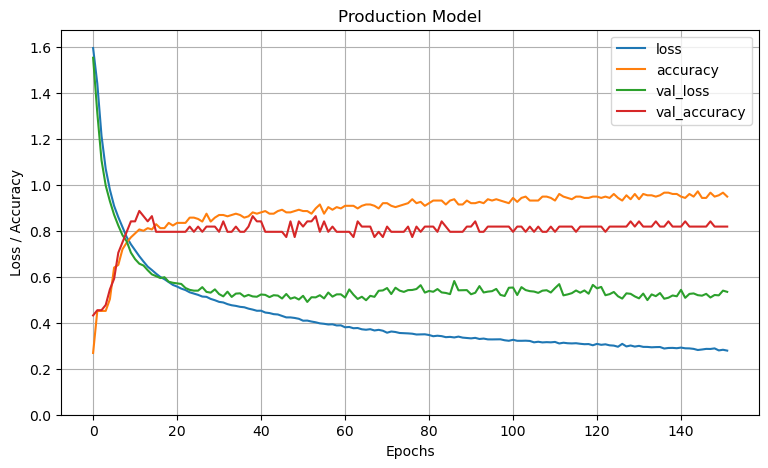

In [13]:
maxes = []
for met in model_prod_fit.history.keys():
    maxes.append(max(model_prod_fit.history[met]))
mmax = max(maxes)

pd.DataFrame(model_prod_fit.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05*mmax)
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Production Model')
plt.show()

In [14]:
# # learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
# # regularization_factors = [0.3, 0.25, 0.2, 0.15, 0.1, 0.5, 0.01, 0.05, 0.001, 0.0005]
# learning_rates = [0.0005, 0.001, 0.005 ,0.01, 0.02]
# regularization_factors = [0.05, 0.01, 0.05, 0.001, 0.0005, 0.0001]
# # Initialize dictionary to hold results
# results = {}

# for lr in learning_rates:
#     for rf in regularization_factors:
#         # Create and train the model
#         model = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
#                                    optimizer='adam', learning_rate=lr, regularization_factor=rf)
#         early_stop = EarlyStopping(monitor='val_loss', patience=50)
#         history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])

#         # Store the results
#         results[(lr, rf)] = {
#             'accuracy': max(history.history['accuracy']),
#             'loss': min(history.history['loss']),
#             'val_accuracy': max(history.history['val_accuracy']),
#             'val_loss': min(history.history['val_loss'])
#         }


In [15]:
# import seaborn as sns

# # Reshape accuracy results into a matrix
# accuracy_results = np.zeros((len(learning_rates), len(regularization_factors)))
# for i, lr in enumerate(learning_rates):
#     for j, rf in enumerate(regularization_factors):
#         accuracy_results[i, j] = results[(lr, rf)]['accuracy']

# # Create a heatmap
# plt.figure(figsize=(10, 4))
# sns.heatmap(accuracy_results, annot=True, fmt=".4f", xticklabels=regularization_factors, yticklabels=learning_rates)
# plt.title('Accuracy')
# plt.xlabel('Regularization Factor')
# plt.ylabel('Learning Rate')
# plt.show()


In [16]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy_scores_train = []
# accuracy_scores_test = []

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]
    
#     # Define early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=100)
#     # Train the model
#     model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
#     # Test your model on the testing set
#     Y_pred_train = model.predict(X_train)
#     Y_pred_test = model.predict(X_test)
    
#     # Convert the prediction probabilities into class predictions
#     Y_pred_train = (Y_pred_train > 0.5).astype(int)
#     Y_pred_test = (Y_pred_test > 0.5).astype(int)
    
    
#     # Evaluate the model's performance on training and testing set
#     accuracy_train = np.mean([accuracy_score(Y_train[:, i], Y_pred_train[:, i]) for i in range(Y_train.shape[1])])
#     accuracy_test = np.mean([accuracy_score(Y_test[:, i], Y_pred_test[:, i]) for i in range(Y_test.shape[1])])
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_test.append(accuracy_test)
    
# # Aggregate the evaluation results across folds
# mean_accuracy_train = np.mean(accuracy_scores_train)
# mean_accuracy_test = np.mean(accuracy_scores_test)
# print(f'Mean training accuracy over {skf.n_splits} folds: {mean_accuracy_train:.6f}')
# print(f'Mean testing accuracy over {skf.n_splits} folds: {mean_accuracy_test:.6f}')

2/2 [==============================] - 0s 4ms/step


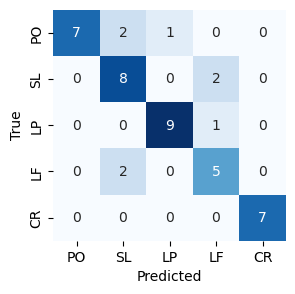

In [17]:


# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


from sklearn.metrics import confusion_matrix

# predict classes for test set
Y_pred = model_prod.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# convert one-hot encoded test labels back to class labels
y_true = np.argmax(Y_test, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.title('Confusion Matrix - Testing Set')
plt.show()

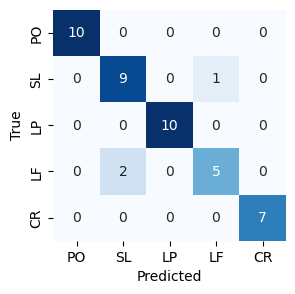

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Specify the labels for the axes
labels = types

# Specify the values for the confusion matrix
confusion_matrix = np.array([
    [10, 0, 0, 0, 0],
    [0, 9, 0, 1, 0],
    [0, 0, 10, 0, 0],
    [0, 2, 0, 5, 0],
    [0, 0, 0, 0, 7]
])

plt.figure(figsize=(3, 3))

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)

# plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [19]:
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_true, y_pred, target_names=types))

              precision    recall  f1-score   support

          PO       1.00      0.70      0.82        10
          SL       0.67      0.80      0.73        10
          LP       0.90      0.90      0.90        10
          LF       0.62      0.71      0.67         7
          CR       1.00      1.00      1.00         7

    accuracy                           0.82        44
   macro avg       0.84      0.82      0.82        44
weighted avg       0.84      0.82      0.82        44



In [20]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 1.31 minutes.
